In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/mushrooms.csv')

In [3]:
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
data_description = dict(data.describe())
data_description['cap-shape'].keys()

Index(['count', 'unique', 'top', 'freq'], dtype='object')

In [5]:
data['target'] = pd.get_dummies(data['class'], drop_first=True)['p']

In [6]:
N_FEATURES = len(data.columns) - 1
print('N_FEATURES = {}'.format(N_FEATURES))

N_FEATURES = 23


In [7]:
FEATURES = list(data.columns)
FEATURES.remove('class')
FEATURES.remove('target')
print('FEATURES = {}'.format(FEATURES))

FEATURES = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


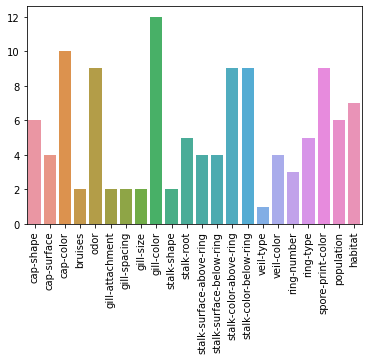

In [8]:
# Number of unique entries
unique = [data_description[f]['unique'] for f in FEATURES]
ax = sns.barplot(x=FEATURES, y=unique)
plt.xticks(rotation=90);

In [11]:
pd.pivot_table(data, index='cap-shape', values='target')

,target
cap-shape,
b,0.106195
c,1.000000
f,0.493655
k,0.724638
s,0.000000
x,0.467177


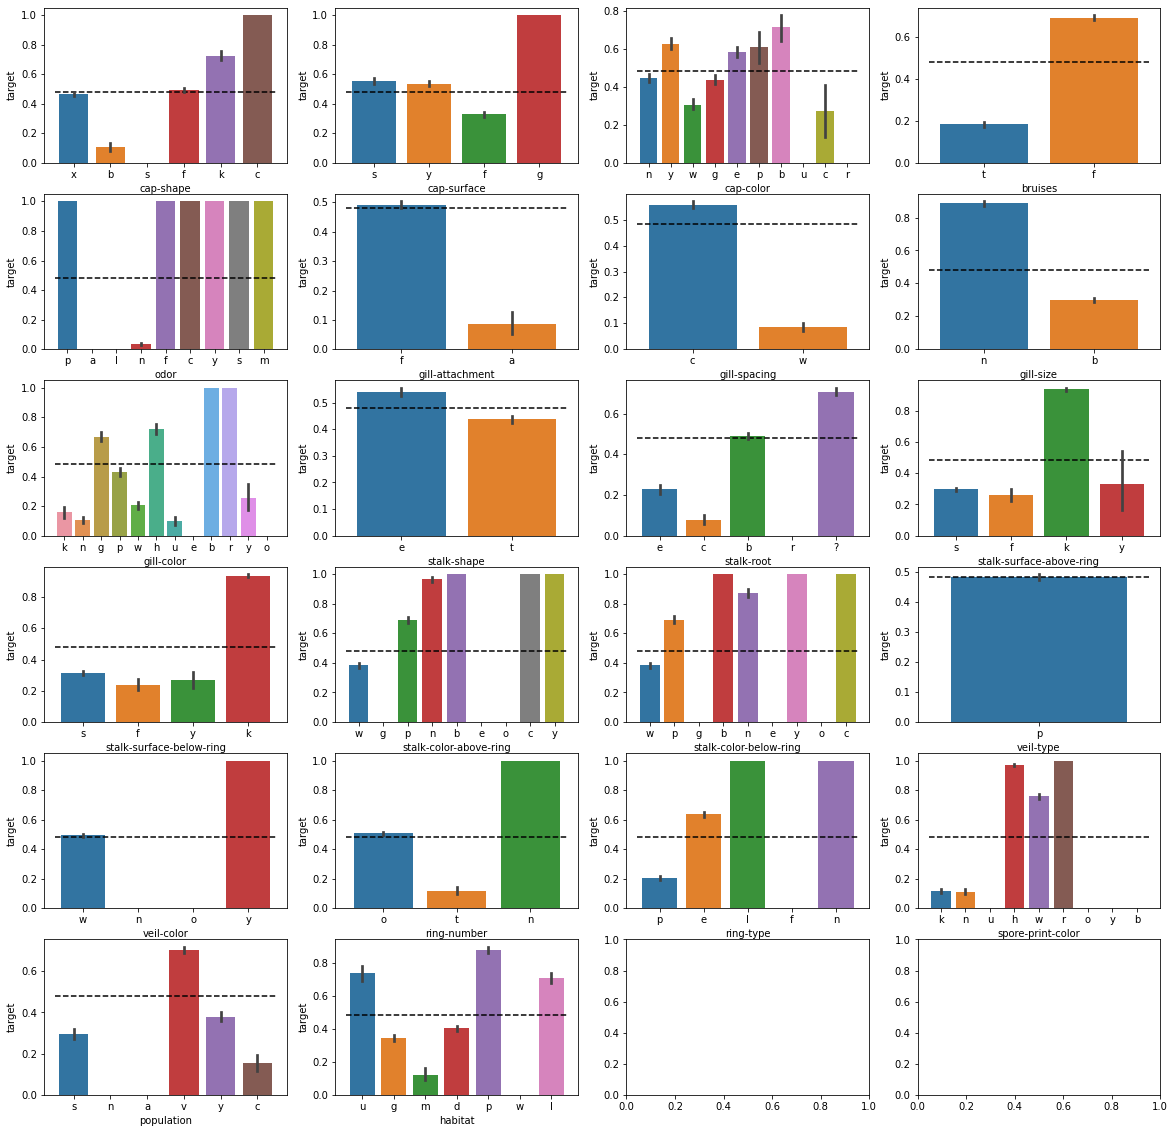

In [20]:
fig, axs = plt.subplots(6, 4, figsize=(20,20))
axs = list(axs.flatten())

MEAN_PROB = data['target'].mean()

for feat, ax in zip(FEATURES, axs):
    ax.set_ylabel('prob.of being poisonous')
    sns.barplot(x=feat, y='target', data=data, ax=ax);
    xlim = ax.get_xlim()
    ax.hlines(MEAN_PROB, xmin=xlim[0], xmax=xlim[1], linestyles='--', color='k')

In [25]:
data_encoded = pd.DataFrame()

In [27]:
import category_encoders as ce

In [32]:
encoder = ce.OneHotEncoder(drop_invariant=True).fit(data[FEATURES])

In [36]:
data_encoded = encoder.transform(data[FEATURES])

In [50]:
len(data_encoded)

8124

- veil-type can be dropped - single category
- odor can be turned into 3 categories

In [21]:
from sklearn.feature_selection import chi2

In [40]:
chi2, pvalues = chi2(X=data_encoded, y=data['target'])

<AxesSubplot:ylabel='Count'>

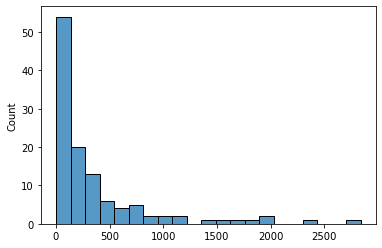

In [47]:
sns.histplot([c for c in chi2 if c < 5000])

In [65]:
selected_features = list()
for c2, feat in zip(chi2, data_encoded.columns):
    if c2 > 100:
        selected_features.append(feat)
print(len(selected_features))

66


### Classification

In [66]:
X = data_encoded[selected_features]
y = data['target']

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
clf = LogisticRegression(C=1).fit(X_train, y_train)

In [71]:
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

In [72]:
from sklearn.metrics import recall_score

In [73]:
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)
print(recall_train)
print(recall_test)

0.9989047097480832
0.9957519116397621


https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

# Building classes

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, kind='one-hot'):
        if kind == 'one-hot':
            self.encoder = ce.OneHotEncoder()
        else:
            raise ValueError('kind parameter value is invalid')
        
    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        return self.encoder.transform(X)

In [79]:
my_encoder = MyEncoder(kind='one-hot')

In [80]:
from sklearn.feature_selection import SelectKBest

In [81]:
from sklearn.pipeline import make_pipeline

In [90]:
from sklearn.feature_selection import chi2
pipe = make_pipeline(ce.OneHotEncoder(), SelectKBest(chi2, k=10), LogisticRegression(C=1))

In [91]:
pipe.get_params()

{'memory': None,
 'steps': [('onehotencoder', OneHotEncoder()),
  ('selectkbest', SelectKBest(score_func=<function chi2 at 0x7fa68d8c7dc0>)),
  ('logisticregression', LogisticRegression(C=1))],
 'verbose': False,
 'onehotencoder': OneHotEncoder(),
 'selectkbest': SelectKBest(score_func=<function chi2 at 0x7fa68d8c7dc0>),
 'logisticregression': LogisticRegression(C=1),
 'onehotencoder__cols': None,
 'onehotencoder__drop_invariant': False,
 'onehotencoder__handle_missing': 'value',
 'onehotencoder__handle_unknown': 'value',
 'onehotencoder__return_df': True,
 'onehotencoder__use_cat_names': False,
 'onehotencoder__verbose': 0,
 'selectkbest__k': 10,
 'selectkbest__score_func': <function sklearn.feature_selection._univariate_selection.chi2(X, y)>,
 'logisticregression__C': 1,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisti